<a href="https://colab.research.google.com/github/arsalanmontazeri/Arsalan-Montazeri/blob/coffee-trend/coffe_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For displaying all of the columns in dataframes
pd.set_option('display.max_column',None)
# For data modeling
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
# For saving models
import pickle

In [ ]:
df=pd.read_csv('index.csv')

In [ ]:
df.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1313 non-null   object 
 1   datetime     1313 non-null   object 
 2   cash_type    1313 non-null   object 
 3   card         1224 non-null   object 
 4   money        1313 non-null   float64
 5   coffee_name  1313 non-null   object 
dtypes: float64(1), object(5)
memory usage: 61.7+ KB


In [ ]:
df.isna().sum()

,0
date,0
datetime,0
cash_type,0
card,89
money,0
coffee_name,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df['date']=pd.to_datetime(df['date'])
df['datetime']=pd.to_datetime(df['datetime'])

In [ ]:
df['cash_type'].value_counts()

,count
cash_type,
card,1224
cash,89


In [ ]:
df['coffee_name'].value_counts()

,count
coffee_name,
Americano with Milk,319
Latte,282
Cappuccino,222
Americano,185
Cortado,123
Hot Chocolate,79
Espresso,59
Cocoa,44


In [ ]:
def creat_features(df):
  df['year']=df['datetime'].dt.year
  df['month']=df['datetime'].dt.month
  df['day']=df['datetime'].dt.day
  df['quarter']=df['datetime'].dt.quarter
  df['dayofweek']=df['datetime'].dt.dayofweek
  df['dayofyear']=df['datetime'].dt.dayofyear
  df['hour']=df['datetime'].dt.hour
  df['week']=df['datetime'].dt.isocalendar().week
  return df

In [ ]:
creat_features(df)

,date,datetime,cash_type,card,money,coffee_name,year,month,day,quarter,dayofweek,dayofyear,hour,week
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.70,Latte,2024,3,1,1,4,61,10,9
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.70,Hot Chocolate,2024,3,1,1,4,61,12,9
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.70,Hot Chocolate,2024,3,1,1,4,61,12,9
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.90,Americano,2024,3,1,1,4,61,13,9
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.70,Latte,2024,3,1,1,4,61,13,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,2024-08-17,2024-08-17 16:31:54.837,card,ANON-0000-0000-0277,23.02,Cortado,2024,8,17,3,5,230,16,33
1309,2024-08-17,2024-08-17 16:33:48.977,card,ANON-0000-0000-0192,32.82,Latte,2024,8,17,3,5,230,16,33
1310,2024-08-17,2024-08-17 18:48:58.852,card,ANON-0000-0000-0456,32.82,Cappuccino,2024,8,17,3,5,230,18,33
1311,2024-08-17,2024-08-17 21:18:56.806,card,ANON-0000-0000-0040,27.92,Americano with Milk,2024,8,17,3,5,230,21,33


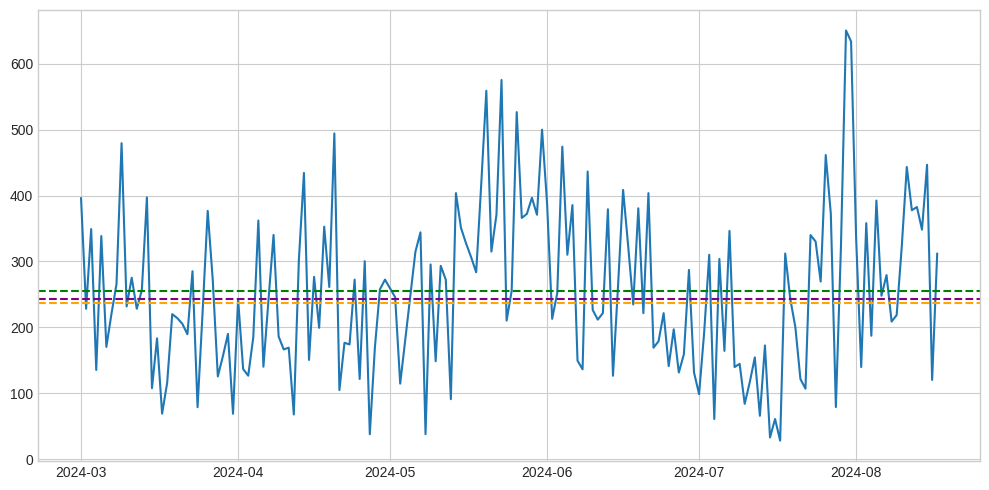

In [ ]:
sales=df.groupby(df['date'].dt.date)['money'].sum()
sales.index=pd.to_datetime(sales.index)
daily_avg=sales.mean()
weekly_avg=sales.resample('W').sum().mean()
monthly_avg=sales.resample('M').sum().mean()
plt.figure(figsize=(10,5))
plt.plot(sales.index,sales.values,label='daily sales')
plt.axhline(daily_avg, color='green', linestyle='--', label=f'Daily Average: ₴{daily_avg:.2f}')
plt.axhline(weekly_avg/ 7, color='purple', linestyle='--', label=f'Weekly Average (Daily Basis): ₴{weekly_avg / 7:.2f}')
plt.axhline(monthly_avg / 30, color='orange', linestyle='--', label=f'Monthly Average (Daily Basis): ₴{monthly_avg / 30:.2f}')

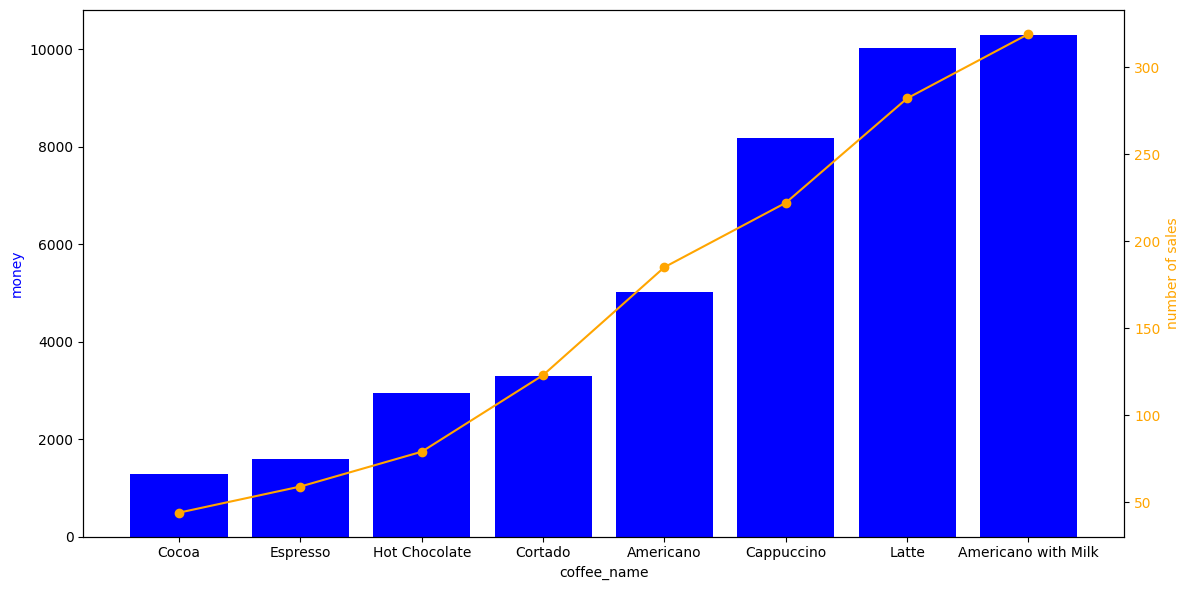

In [ ]:
coffe_sales=df.groupby('coffee_name')['money'].sum().reset_index().sort_values(by='money')
count_sales=df.groupby('coffee_name')['money'].count().reset_index().sort_values(by='money')
fig,ax1=plt.subplots(figsize=(12,6))
ax1.bar(data=coffe_sales,x='coffee_name',height='money',color='blue')
ax1.set_xlabel('coffee_name')
ax1.set_ylabel('money',color='blue')
ax2=ax1.twinx()
ax2.plot(count_sales['coffee_name'], count_sales['money'],color='orange',marker='o')
ax2.set_ylabel('number of sales',color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
fig.tight_layout()
plt.show()

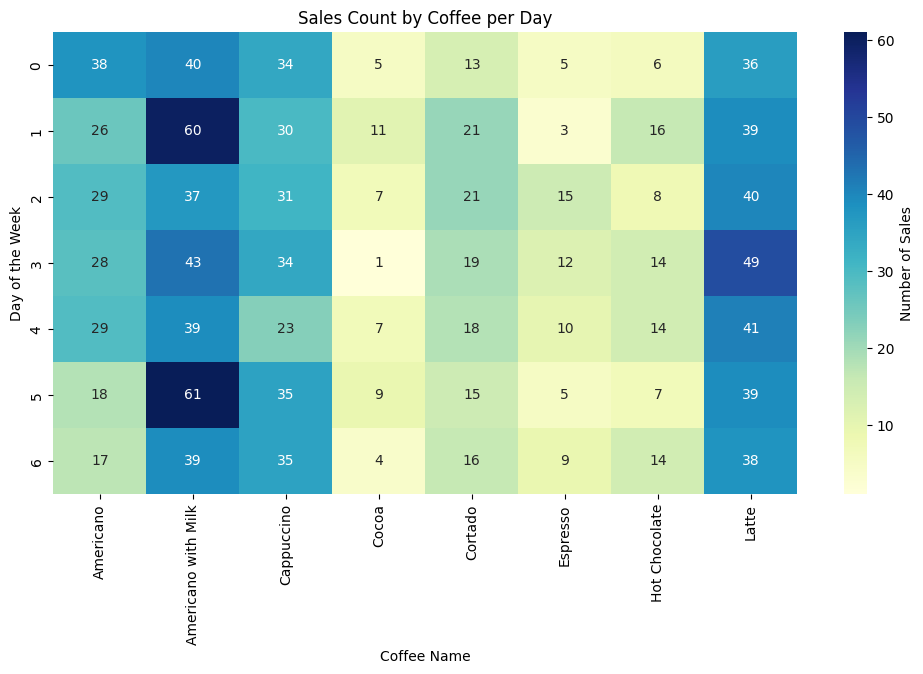

In [ ]:
sales_by_coffee_day=df.groupby(['dayofweek','coffee_name'])['money'].count().unstack().fillna(0)
plt.figure(figsize=(12,6))
sns.heatmap(sales_by_coffee_day,annot=True,cmap='YlGnBu',cbar_kws={'label': 'Number of Sales'})
plt.title('Sales Count by Coffee per Day')
plt.xlabel('Coffee Name')
plt.ylabel('Day of the Week')
plt.show()


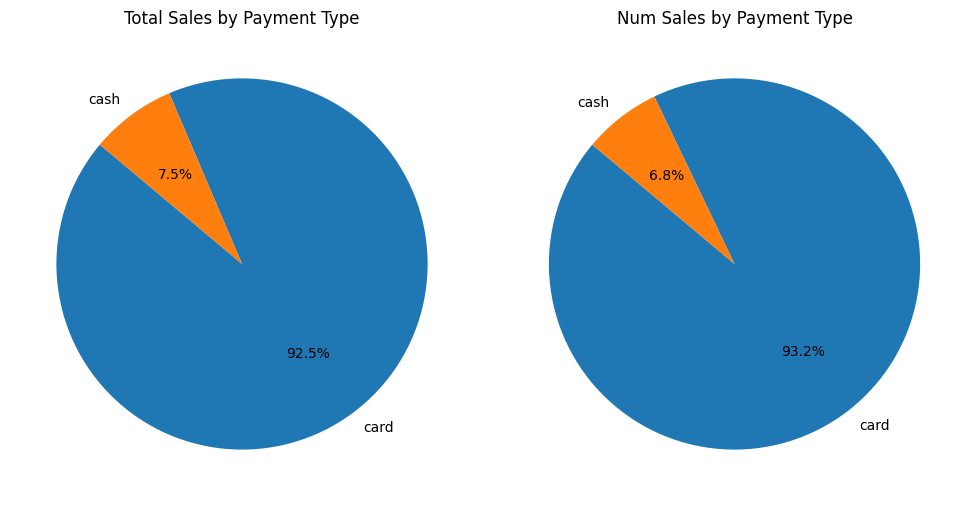

In [ ]:
sales_by_payment_type=df.groupby('cash_type')['money'].sum()
sales_count_payment_type=df.groupby('cash_type')['money'].count()
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].pie(sales_by_payment_type,labels=sales_by_payment_type.index,autopct='%1.1f%%', startangle=140)
axes[0].set_title('Total Sales by Payment Type')
axes[1].pie(sales_count_payment_type,labels=sales_count_payment_type.index,autopct='%1.1f%%',startangle=140)
axes[1].set_title('Num Sales by Payment Type')
plt.tight_layout()
plt.show()

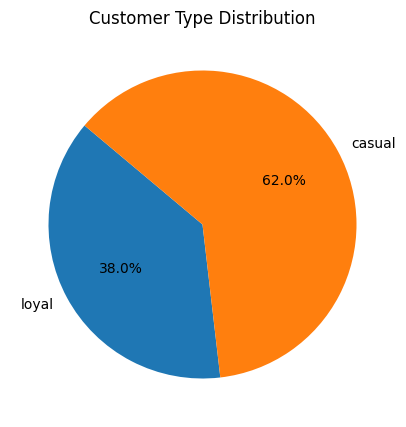

In [ ]:
customer=df['card'].value_counts().reset_index()
loyal_customer=customer[customer['count']>1].reset_index()
casual_customer=customer[customer['count']==1].reset_index()
loyal_customer_count=loyal_customer['card'].nunique()
casual_customer_count=casual_customer['card'].nunique()
coustomer_count=pd.Series([loyal_customer_count,casual_customer_count],index=['loyal','casual'])
plt.figure(figsize=(8,5))
plt.pie(coustomer_count,labels=coustomer_count.index,autopct='%1.1f%%',startangle=140)
plt.title('Customer Type Distribution')
plt.show()

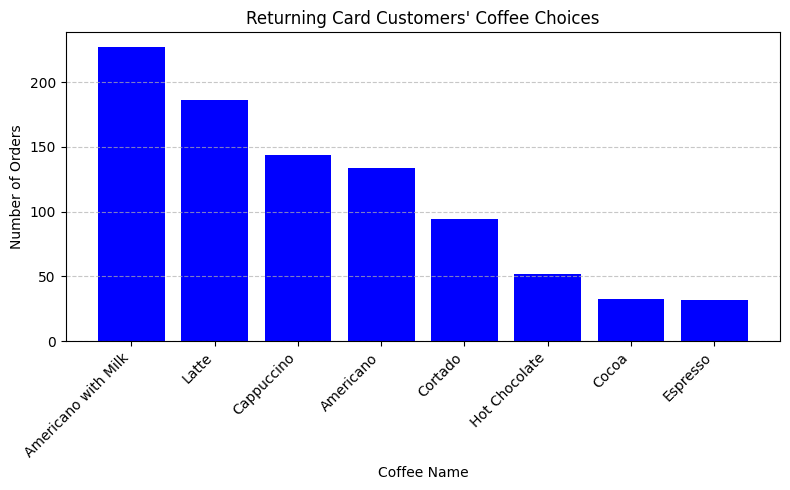

In [ ]:
loyal_customer_df=df[df['card'].isin(loyal_customer['card'])]
loyal_coffee=loyal_customer_df['coffee_name'].value_counts().reset_index()
plt.figure(figsize=(8,5))
plt.bar(loyal_coffee['coffee_name'],loyal_coffee['count'],color='blue')
plt.title("Returning Card Customers' Coffee Choices")
plt.xlabel('Coffee Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45,ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
loyal_customer_df.head()

,date,datetime,cash_type,card,money,coffee_name,year,month,day,quarter,dayofweek,dayofyear,hour,week
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,2024,3,1,1,4,61,10,9
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,1,4,61,12,9
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,2024,3,1,1,4,61,12,9
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,2024,3,1,1,4,61,13,9
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,2024,3,1,1,4,61,13,9


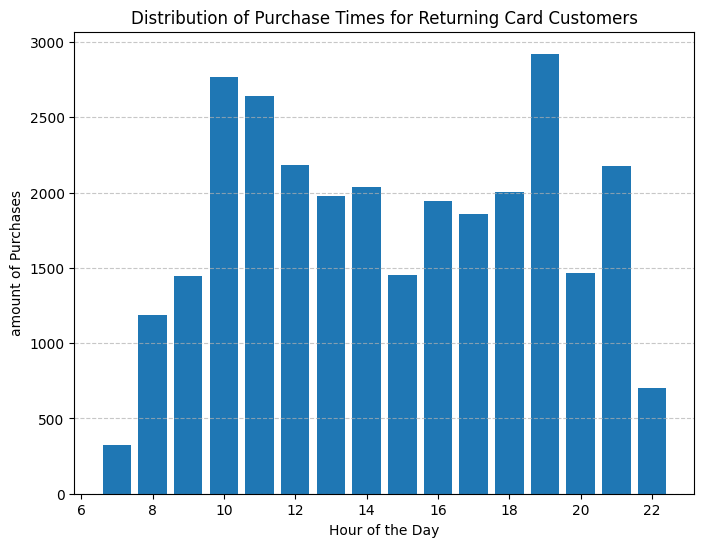

In [ ]:
loyal_purchasing_hour=loyal_customer_df.groupby('hour')['money'].sum().reset_index()
plt.figure(figsize=(8,6))
plt.bar(loyal_purchasing_hour['hour'],loyal_purchasing_hour['money'])
plt.title('Distribution of Purchase Times for Returning Card Customers')
plt.xlabel('Hour of the Day')
plt.ylabel('amount of Purchases')
plt.grid(axis='y',linestyle='--',alpha=.7)
plt.show()

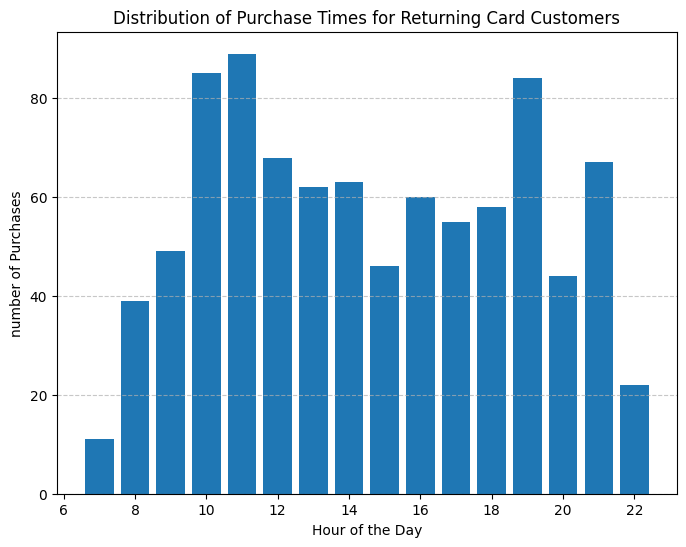

In [ ]:
loyal_purchasing_hour=loyal_customer_df.groupby('hour')['money'].count().reset_index()
plt.figure(figsize=(8,6))
plt.bar(loyal_purchasing_hour['hour'],loyal_purchasing_hour['money'])
plt.title('Distribution of Purchase Times for Returning Card Customers')
plt.xlabel('Hour of the Day')
plt.ylabel('number of Purchases')
plt.grid(axis='y',linestyle='--',alpha=.7)
plt.show()

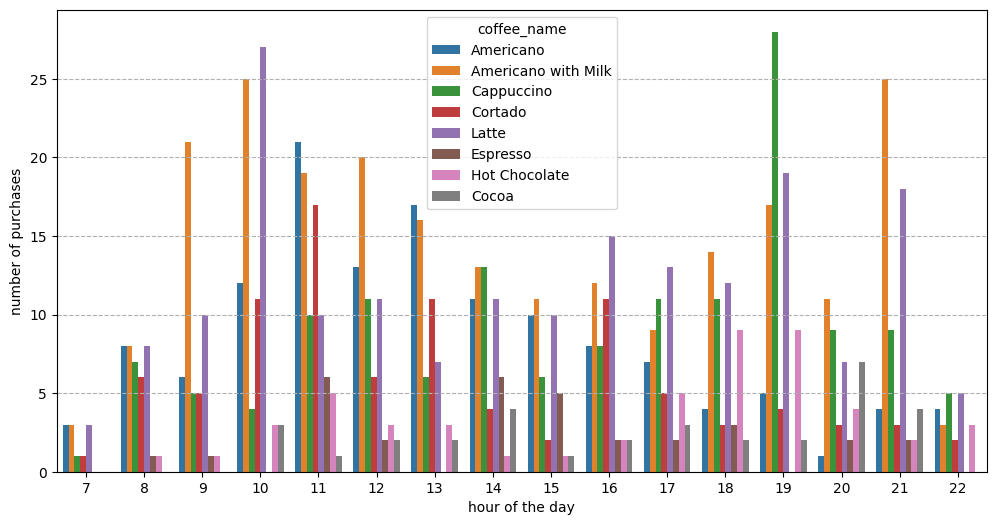

In [ ]:
loyal_purchasing=loyal_customer_df.groupby(['hour','coffee_name'])['money'].count().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(data=loyal_purchasing,x='hour',y='money',hue='coffee_name')
plt.xlabel('hour of the day')
plt.ylabel('number of purchases')
plt.grid(axis='y',linestyle='--')
plt.show()


In [ ]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,)
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",

        )
    return ax

<ipython-input-22-3d5698250869>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<ipython-input-22-3d5698250869>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
<ipython-input-22-3d5698250869>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
<ipython-input-22-3d5698250869>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


<Axes: title={'center': 'Seasonal Plot (quarter/dayofweek)'}, xlabel='dayofweek', ylabel='money'>

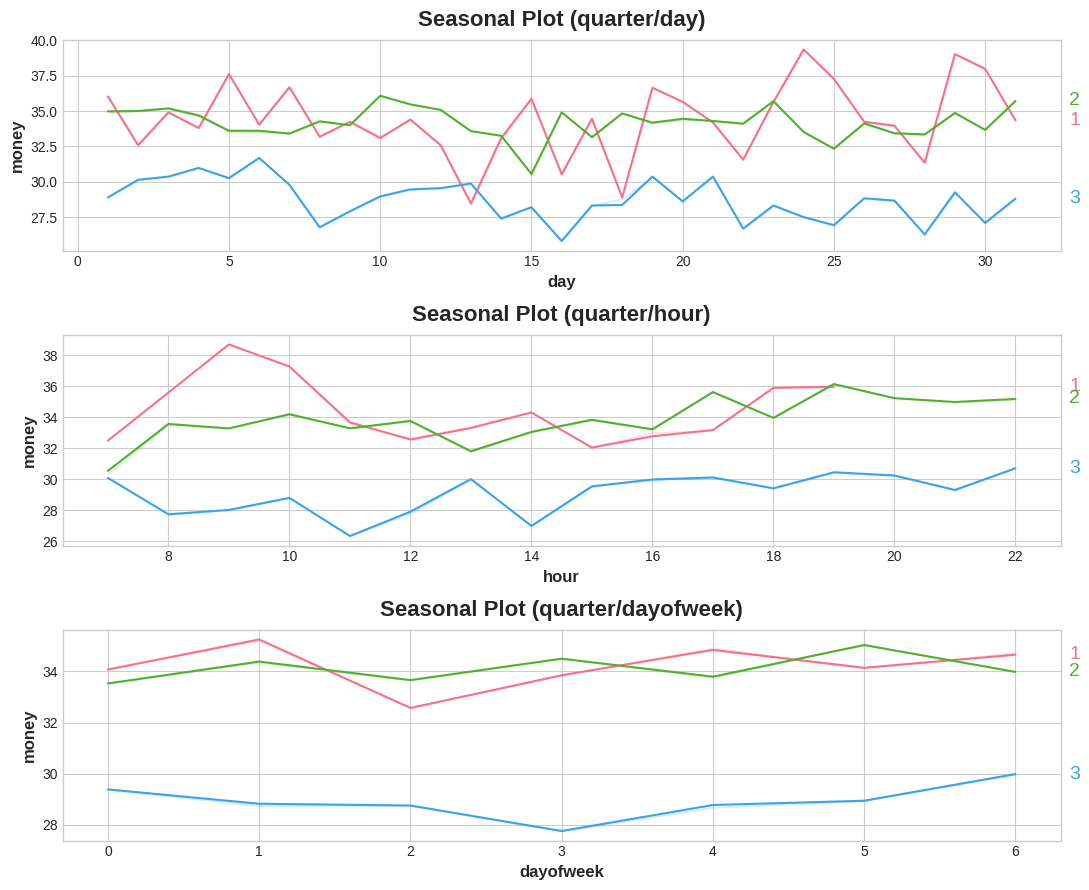

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(11, 9))
seasonal_plot(df, y="money", period="quarter", freq="day", ax=ax0)
seasonal_plot(df, y="money", period="quarter", freq="hour", ax=ax1)
seasonal_plot(df, y="money", period="quarter", freq="dayofweek", ax=ax2)